In [53]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization, Lambda
from keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
import cv2
import pandas as pd
import random
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [54]:
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.16.1


In [55]:
# Path to the folder
folder_path = './data'

# Using os.scandir() to iterate through entries and count files
file_count = sum(1 for entry in os.scandir(folder_path) if entry.is_file())

print(f"Number of files in the folder: {file_count}")

Number of files in the folder: 66550


In [56]:
data = pd.read_csv('./data/recorded_data.csv')
print("data",data.shape)

data[200:210]

data (66549, 3)


,filename,angle,speed
200,2024-06-22 09-33-46.310033.png,0.048,10.0
201,2024-06-22 09-33-46.396947.png,0.048,10.0
202,2024-06-22 09-33-46.461365.png,0.048,10.0
203,2024-06-22 09-33-46.529948.png,0.048,10.0
204,2024-06-22 09-33-46.592665.png,0.048,10.0
205,2024-06-22 09-33-46.656960.png,0.052,10.0
206,2024-06-22 09-33-46.721000.png,0.056,10.0
207,2024-06-22 09-33-46.778584.png,0.056,10.0
208,2024-06-22 09-33-46.841179.png,0.056,10.0
209,2024-06-22 09-33-46.907452.png,0.056,10.0


In [57]:
count = data[data['angle'] == 0]['angle'].count()
print(count)

13736


Text(0.5, 1.0, 'Training set')

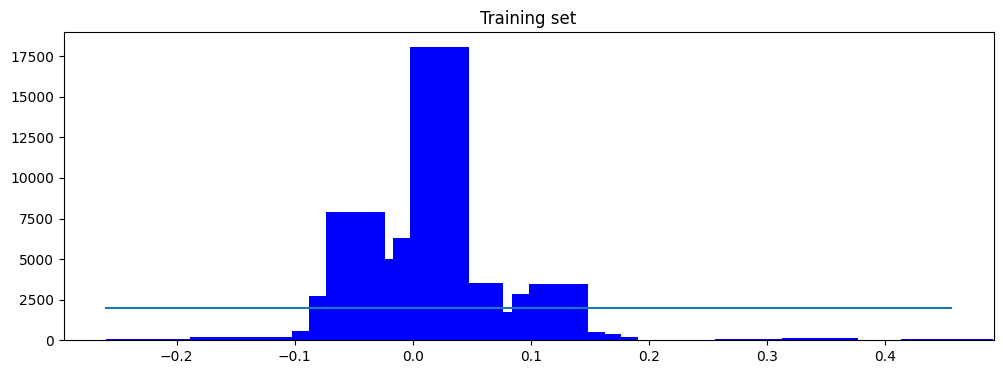

In [58]:
samples_per_bin = 2000
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.hist(data['angle'], bins=50, width=0.05, color='blue')
plt.plot((np.min(data['angle']), np.max(data['angle'])),(samples_per_bin, samples_per_bin))
axes.set_title('Training set')

/var/folders/dq/9c_cwcqd6w1f3rwv2wt70vq40000gn/T/ipykernel_25880/1091875273.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_data = data.groupby('angle_bin').apply(sample_data_per_bin).reset_index(drop=True)
/var/folders/dq/9c_cwcqd6w1f3rwv2wt70vq40000gn/T/ipykernel_25880/1091875273.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('angle_bin').apply(sample_data_per_bin).reset_index(drop=True)


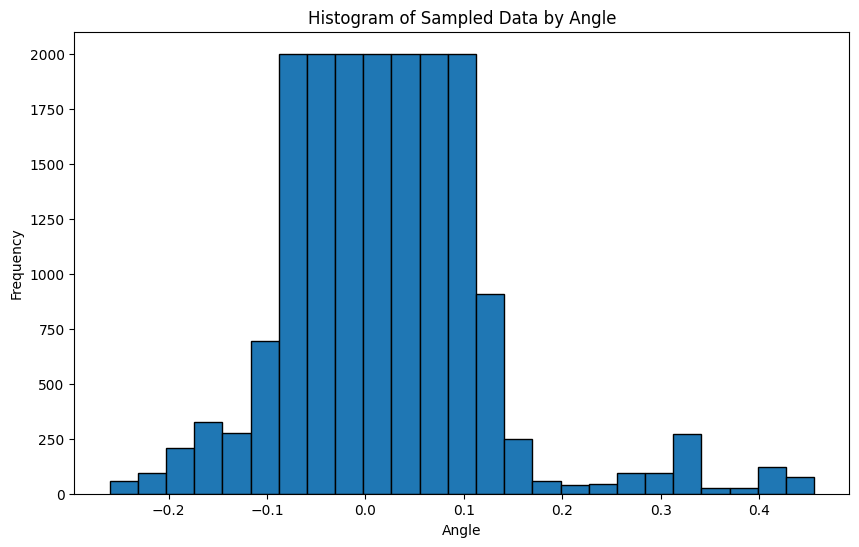

In [59]:
# Divide 'angle' into 25 bins
data['angle_bin'] = pd.cut(data['angle'], bins=25)

# Function to sample up to 2000 data points per bin
def sample_data_per_bin(bin_data):
    if len(bin_data) > samples_per_bin:
        return bin_data.sample(n=samples_per_bin, random_state=42)
    else:
        return bin_data

# Group by bins and apply the sampling function
sampled_data = data.groupby('angle_bin').apply(sample_data_per_bin).reset_index(drop=True)

# Reset indices
sampled_data.reset_index(drop=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(sampled_data['angle'], bins=25, edgecolor='k')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.title('Histogram of Sampled Data by Angle')
plt.show()

In [60]:
data = sampled_data
data['angle'] = data['angle'] * 10

In [61]:
count = data[data['angle'] == 0]['angle'].count()
print(count)

1376


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Create bins for the continuous target variable
data['angle_bin'] = pd.qcut(data['angle'], q=10, duplicates='drop')  # Adjust q for different number of bins if needed

# First split into training+validation (90%) and testing (10%) using stratified sampling on bins
train_valid, test = train_test_split(data, test_size=0.1, random_state=6, stratify=data['angle_bin'])

# Now split the training+validation set into training (77.78% of the original) and validation (22.22% of the original)
train, valid = train_test_split(train_valid, test_size=0.2222, random_state=6, stratify=train_valid['angle_bin'])

# Extract the filename and angle columns for each split
X_train, y_train = train['filename'], train['angle']
X_valid, y_valid = valid['filename'], valid['angle']
X_test, y_test = test['filename'], test['angle']

# Calculate the total number of samples
total_samples = len(data['filename'])

# Calculate percentages
train_percentage = (len(X_train) / total_samples) * 100
valid_percentage = (len(X_valid) / total_samples) * 100
test_percentage = (len(X_test) / total_samples) * 100

# Print the results with percentages

print('Total Samples: {}\n'.format(total_samples))
print('Training Samples: {} ({:.2f}%)\nValid Samples: {} ({:.2f}%)\nTesting Samples: {} ({:.2f}%)'.format(
    len(X_train), train_percentage, len(X_valid), valid_percentage, len(X_test), test_percentage
))


Total Samples: 17673

Training Samples: 12370 (69.99%)
Valid Samples: 3535 (20.00%)
Testing Samples: 1768 (10.00%)


Text(0.5, 1.0, 'Testing set')

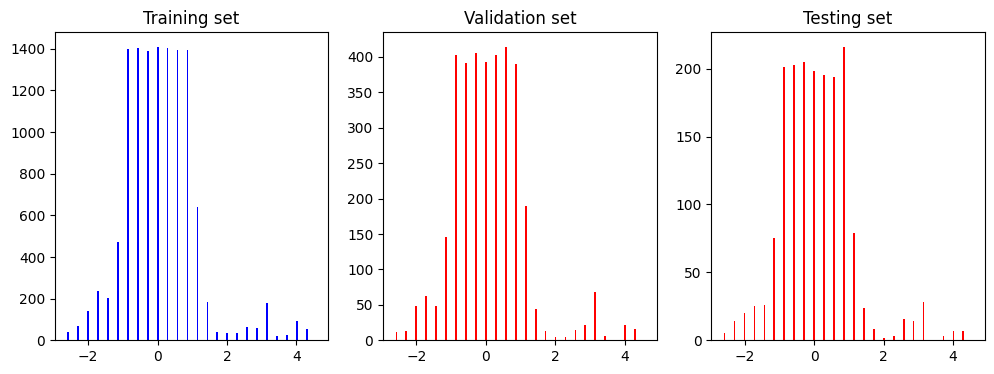

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(y_train, bins=25, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=25, width=0.05, color='red')
axes[1].set_title('Validation set')
axes[2].hist(y_test, bins=25, width=0.05, color='red')
axes[2].set_title('Testing set')

In [64]:
X_test

12737    2024-06-22 10-26-31.826385.png
14224    2024-06-22 10-42-22.846034.png
7062     2024-06-22 09-49-56.854997.png
8820     2024-06-22 09-34-53.305455.png
5282     2024-06-22 09-49-57.517159.png
                      ...              
17038    2024-06-22 10-08-07.222853.png
3560     2024-06-22 09-40-02.384098.png
7300     2024-06-22 10-01-47.492529.png
13459    2024-06-22 10-18-15.556429.png
15230    2024-06-22 10-39-41.268153.png
Name: filename, Length: 1768, dtype: object

In [65]:
# Image preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = img[150:230, :]  # Crop the image
    img = img / 255.0  # Normalize the image
    return img



./data/2024-06-22 10-23-05.387938.png
Original Image Shape: (240, 320, 3)
Processed Image Shape: (80, 320)


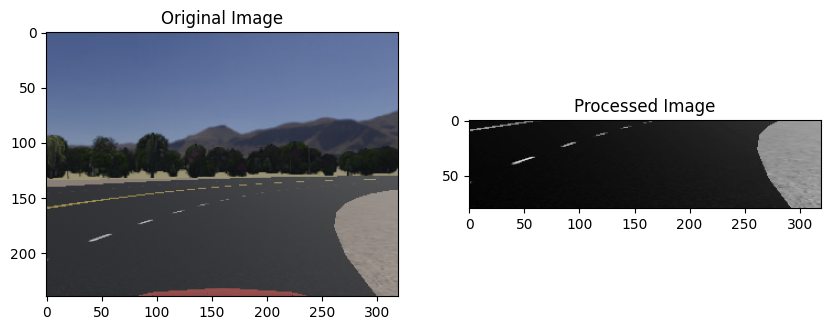

In [66]:
def show_example_image(img_path):
    original_img = cv2.imread(img_path)
    processed_img = preprocess_image(img_path)
    print('Original Image Shape:', original_img.shape)
    print('Processed Image Shape:', processed_img.shape)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title('Processed Image')
    plt.imshow(processed_img, cmap='gray')
    plt.show()
print(folder_path+'/'+X_train.iloc[0])
show_example_image(folder_path+'/'+X_train.iloc[0])

In [15]:
def data_generator(X, y, batch_size=32):
    while True:
        for offset in range(0, len(X), batch_size):
            batch_X, batch_y = X[offset:offset+batch_size], y[offset:offset+batch_size]
            images = []
            angles = []
            for img_name, angle in zip(batch_X, batch_y):
                img_path = folder_path + '/' + img_name
                img = preprocess_image(img_path)
                images.append(img)
                angles.append(angle)
            X_batch = np.array(images)
            y_batch = np.array(angles)
            yield X_batch[..., np.newaxis], y_batch

In [79]:
model = Sequential([
    Lambda(lambda x: x, input_shape=(80, 320, 1)),  # No normalization needed as it's already done
    Conv2D(24, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)


])

model.compile(optimizer='adam', loss='mse',metrics=['mse','cosine_similarity','mae','mean_squared_error'])

/Users/sortega/miniforge3/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)               │ (None, 80, 320, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 38, 158, 24)    │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 17, 77, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 37, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 35, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 3, 33, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6336)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │       633,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769,419 (2.94 MB)

 Trainable params: 769,419 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

None


In [81]:
batch_size = 32
train_generator = data_generator(X_train, y_train, batch_size)
valid_generator = data_generator(X_valid, y_valid, batch_size)

model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='cosine_similarity')

history=model.fit(train_generator, 
          steps_per_epoch=len(X_train) // batch_size, 
          validation_data=valid_generator, 
          validation_steps=len(X_valid) // batch_size, 
          epochs=100,
          callbacks=[model_checkpoint])


Epoch 1/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - cosine_similarity: 0.5358 - loss: 0.7014 - mae: 0.5490 - mean_squared_error: 0.7014 - mse: 0.7014 - val_cosine_similarity: 0.7011 - val_loss: 0.2876 - val_mae: 0.3447 - val_mean_squared_error: 0.2876 - val_mse: 0.2876
Epoch 2/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - cosine_similarity: 0.7392 - loss: 0.2557 - mae: 0.3190 - mean_squared_error: 0.2557 - mse: 0.2557 - val_cosine_similarity: 0.7559 - val_loss: 0.2380 - val_mae: 0.3072 - val_mean_squared_error: 0.2380 - val_mse: 0.2380
Epoch 3/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - cosine_similarity: 0.7663 - loss: 0.2009 - mae: 0.2859 - mean_squared_error: 0.2009 - mse: 0.2009 - val_cosine_similarity: 0.7576 - val_loss: 0.1790 - val_mae: 0.2647 - val_mean_squared_error: 0.1790 - val_mse: 0.1790
Epoch 4/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - cosine_similarity: 0.7686 - loss: 0.1644 - mae: 0.2572 - mean_squared_error: 0.1644 - mse: 0.1644 - val_cosine_sim

In [19]:
model = load_model('Grises_model_ok.keras', safe_mode=False)

2024-06-23 14:19:38.637893: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-06-23 14:19:38.637918: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-23 14:19:38.637923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-23 14:19:38.637943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-23 14:19:38.637958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2024-06-23 14:19:47.216415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


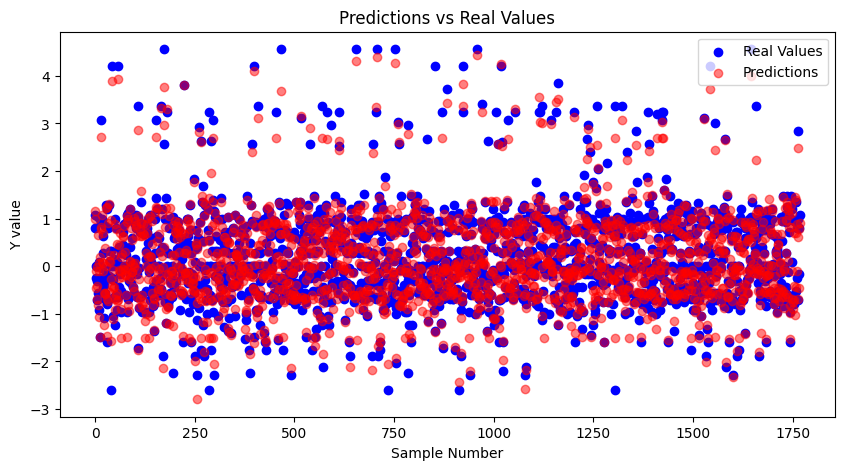

In [20]:
y_pred = model.predict(np.array([preprocess_image(folder_path + '/' + img_name) for img_name in X_test])[:, :, :, np.newaxis])

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, c='blue', label='Real Values')
plt.scatter(range(len(y_pred)), y_pred, c='red', label='Predictions', alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Y value')
plt.legend()
plt.title('Predictions vs Real Values')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


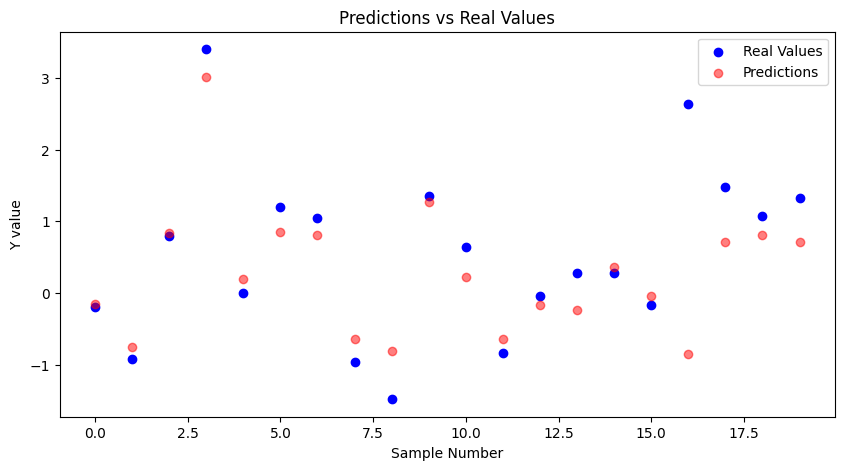

In [ ]:
num_samples = 20
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
X_test_sample = [X_test.iloc[i] for i in random_indices]
y_test_sample = [y_test.iloc[i] for i in random_indices]

y_pred_sample = model.predict(np.array([preprocess_image(folder_path + '/' + img_name) for img_name in X_test_sample])[:, :, :, np.newaxis])

plt.figure(figsize=(10, 5))
plt.scatter(range(num_samples), y_test_sample, c='blue', label='Real Values')
plt.scatter(range(num_samples), y_pred_sample, c='red', label='Predictions', alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Y value')
plt.legend()
plt.title('Predictions vs Real Values')
plt.show()

In [ ]:
model.save('Grises_model_ok.keras')

In [23]:
model.save('Grises_model_ok')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=Grises_model_ok.

<Figure size 2000x500 with 0 Axes>

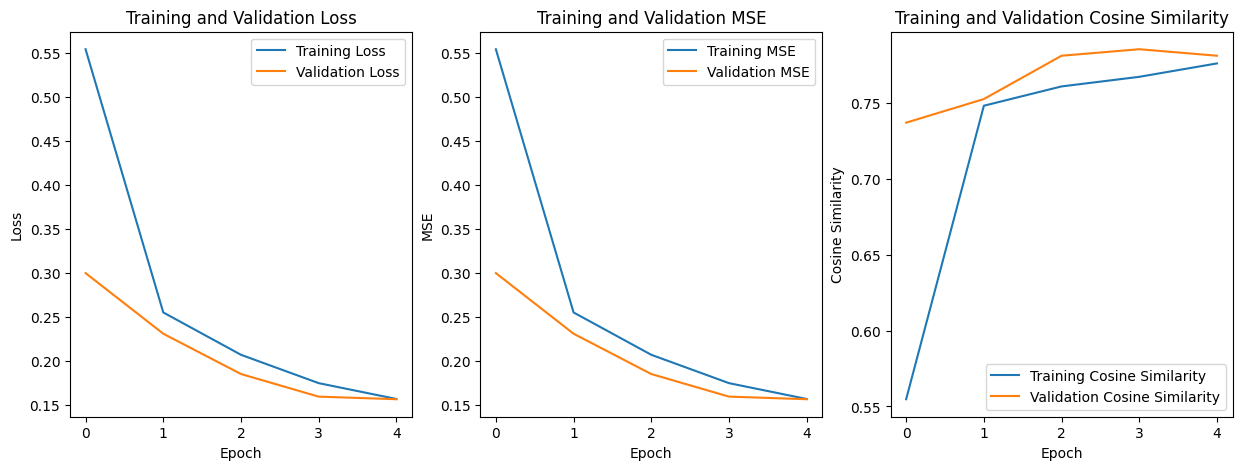

In [ ]:
# Plot the training history
plt.figure(figsize=(20, 5))

# Plot loss
# Plot the training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot MSE
plt.subplot(1, 3, 2)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Validation MSE')

# Plot Cosine Similarity
plt.subplot(1, 3, 3)
plt.plot(history.history['cosine_similarity'], label='Training Cosine Similarity')
plt.plot(history.history['val_cosine_similarity'], label='Validation Cosine Similarity')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.title('Training and Validation Cosine Similarity')

plt.show()


In [ ]:
num_samples = 20
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
X_test_sample = [X_test.iloc[i] for i in random_indices]
y_test_sample = [y_test.iloc[i] for i in random_indices]

# Preprocess the images and make predictions
X_test_processed = np.array([preprocess_image(folder_path + '/' + img_name) for img_name in X_test_sample])[:, :, :, np.newaxis]
y_pred_sample = model.predict(X_test_processed).flatten()

# Calculate MSE and Cosine Similarity for each sample
mse_values = [mean_squared_error([real], [pred]) for real, pred in zip(y_test_sample, y_pred_sample)]
cosine_similarity_values = [cosine_similarity([[real]], [[pred]])[0][0] for real, pred in zip(y_test_sample, y_pred_sample)]

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Real': y_test_sample,
    'Predicted': y_pred_sample,
    'MSE': mse_values,
    'Cosine Similarity': cosine_similarity_values
})

# Display the table
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
    Real  Predicted       MSE  Cosine Similarity
0  -0.24  -0.455444  0.046416                1.0
1   0.28   0.446515  0.027727                1.0
2   1.08   0.765668  0.098804                1.0
3   0.60   0.895456  0.087294                1.0
4  -0.36  -0.506763  0.021539                1.0
5  -0.44  -0.248526  0.036662                1.0
6   0.00  -0.038712  0.001499                0.0
7   0.00  -0.039945  0.001596                0.0
8   0.00   0.120079  0.014419                0.0
9   1.04   0.881326  0.025177                1.0
10  0.92   0.790046  0.016888                1.0
11 -0.16  -0.461067  0.090641                1.0
12 -0.24  -0.323070  0.006901                1.0
13  0.84   0.141693  0.487632                1.0
14  0.32   0.388648  0.004712                1.0
15 -1.40  -1.659163  0.067165                1.0
16  1.00   0.642866  0.127545                1.0
17  0.44   0.377103  0.003956                1.0
18  0.32   0.386414  0.004411  

In [ ]:
# Preprocess the entire test set and make predictions
X_test_processed_all = np.array([preprocess_image(folder_path + '/' + img_name) for img_name in X_test])[:, :, :, np.newaxis]
y_pred_all = model.predict(X_test_processed_all).flatten()

# Create a DataFrame with the real and predicted values for easier plotting
results_all_df = pd.DataFrame({
    'Real': y_test,
    'Predicted': y_pred_all
})

# Display the first few rows of the DataFrame
print(results_all_df.head())


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
       Real  Predicted
12737  0.80   0.718613
14224  1.08   0.830686
7062  -0.24  -0.506065
8820   0.00   0.071362
5282  -0.32  -0.465362


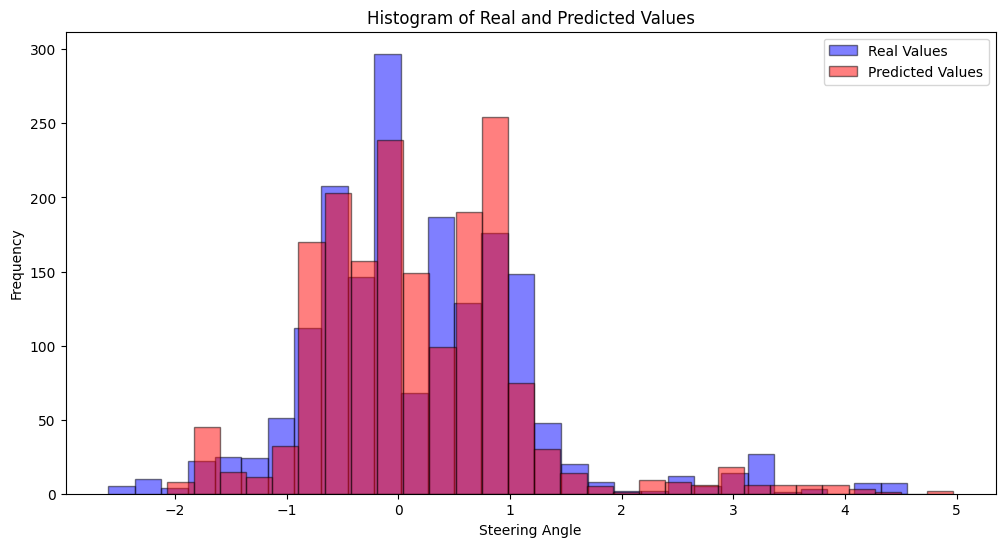

In [ ]:
# Plot histograms of the real and predicted values
plt.figure(figsize=(12, 6))

# Histogram for real values
plt.hist(results_all_df['Real'], bins=30, alpha=0.5, label='Real Values', color='blue', edgecolor='black')

# Histogram for predicted values
plt.hist(results_all_df['Predicted'], bins=30, alpha=0.5, label='Predicted Values', color='red', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Real and Predicted Values')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()


In [22]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.4.0
appnope                      0.1.4
archspec                     0.2.3
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.15.0
beautifulsoup4               4.12.3
bleach                       6.1.0
boltons                      24.0.0
Brotli                       1.1.0
certifi                      2024.6.2
cffi                         1.16.0
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
conda                        24.5.0
conda-libmamba-solver        24.1.0
conda-package-handling       2.2.0
conda_package_streaming      0.9.0
contourpy                    1.2